In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [9]:
# data loading
df = pd.read_csv('filtered_data_0506.csv')
df.head()


,Time,Type,Price,Volume,source_file,day_number,adjusted_time,adjusted_time_seconds
0,0 days 00:00:06.572000,bid,266,6,UoB_Set01_2025-01-02LOBs_LOB_sorted_filtered.csv,0,0 days 00:00:06.572000,6.572
1,0 days 00:00:06.634000,bid,266,6,UoB_Set01_2025-01-02LOBs_LOB_sorted_filtered.csv,0,0 days 00:00:06.634000,6.634
2,0 days 00:00:07.068000,bid,266,6,UoB_Set01_2025-01-02LOBs_LOB_sorted_filtered.csv,0,0 days 00:00:07.068000,7.068
3,0 days 00:00:07.347000,bid,266,6,UoB_Set01_2025-01-02LOBs_LOB_sorted_filtered.csv,0,0 days 00:00:07.347000,7.347
4,0 days 00:00:08.184000,bid,266,6,UoB_Set01_2025-01-02LOBs_LOB_sorted_filtered.csv,0,0 days 00:00:08.184000,8.184


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
# set seed
torch.manual_seed(42)

# min-max normalization
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df[['Price']]), columns=['Price'])

# convert to tensor
tensor_data = torch.FloatTensor(df_normalized.values)

# create sequences
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append(seq)
        labels.append(label)
    return torch.stack(sequences), torch.stack(labels)

# setting hyperparameters
input_size = 1  # set input data's feature dimension
hidden_size = 64
output_size = 1  # set output data's feature dimension
seq_length = 10  # set sequence length

# create sequences
sequences, labels = create_sequences(tensor_data, seq_length)

# split data
train_size = int(len(sequences) * 0.80)
test_size = len(sequences) - train_size
train_sequences, test_sequences = sequences[:train_size], sequences[train_size:]
train_labels, test_labels = labels[:train_size], labels[train_size:]

# create data loader
train_dataset = TensorDataset(train_sequences, train_labels)
test_dataset = TensorDataset(test_sequences, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [13]:
print(train_sequences.size(),test_sequences.size())
print(train_labels.view(train_labels.size(0)).size(),test_labels.size())

torch.Size([4911931, 10, 1]) torch.Size([1227983, 10, 1])
torch.Size([4911931]) torch.Size([1227983, 1, 1])


In [14]:
# define model
class GRU(nn.Module):
    # define model
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2):
        super(GRU, self).__init__()
        # hidden dimensions
        self.hidden_size = hidden_size
        # number of hidden layers
        self.num_layers = num_layers

        self.rnn = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)

        # fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    # define the forward propagation function
    def forward(self, x):

        # initialize hidden state with zeros
        hn = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        hn = hn.to(device)
        out, _ = self.rnn(x,hn)

        out = self.fc(out[:, -1, :])

        return out

# define evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    all_labels = []
    all_predictions = []

    # without computing gradients
    with torch.no_grad():
        for batch_sequences, batch_labels in test_loader:
            batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)

            # forward pass
            outputs = model(batch_sequences)
            loss = criterion(outputs.squeeze(), batch_labels.squeeze())
            # collect results
            all_labels.extend(batch_labels.cpu().numpy().flatten())
            all_predictions.extend(outputs.cpu().numpy().flatten())

            # compute loss
            test_loss += loss.item()

    # calculate average loss
    average_test_loss = test_loss / len(test_loader)

    # calculate metrics
    mae = mean_absolute_error(all_labels, all_predictions)
    mse = mean_squared_error(all_labels, all_predictions)
    rmse = sqrt(mse)

    return average_test_loss, mae, mse, rmse,all_labels,all_predictions

In [15]:
# create model
model = GRU(input_size, hidden_size, output_size, num_layers=1, dropout=0.2).to(device)

# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# create dataframe to save results
df_results = pd.DataFrame(columns=['Epoch', 'Train Loss','Test Loss', 'Test MAE', 'Test MSE', 'Test RMSE'])

# train model
num_epochs = 50

for epoch in range(num_epochs):
    
    model.train()
    for batch_sequences, batch_labels in train_loader:
        batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_sequences)

        loss = criterion(outputs.squeeze(), batch_labels.squeeze())
        loss.backward()
        optimizer.step()

    # evaluate model
    test_loss, test_mae, test_mse, test_rmse,test_label,predicted_labels = evaluate_model(model, test_loader, criterion)
    print(f'Epoch [{epoch+1}/{num_epochs}],Train Loss: {loss.item():.6f}, Test Loss: {test_loss:.6f}, Test MAE: {test_mae:.4f}, Test MSE: {test_mae:.4f}, Test RMSE: {test_rmse:.4f}')
    # save results
    df_results.loc[len(df_results)] = [epoch+1, loss.item(), test_loss, test_mae, test_mse, test_rmse]

Epoch [1/50],Train Loss: 0.000068, Test Loss: 0.000151, Test MAE: 0.0059, Test MSE: 0.0059, Test RMSE: 0.0123
Epoch [2/50],Train Loss: 0.000427, Test Loss: 0.000149, Test MAE: 0.0059, Test MSE: 0.0059, Test RMSE: 0.0122
Epoch [3/50],Train Loss: 0.000180, Test Loss: 0.000144, Test MAE: 0.0047, Test MSE: 0.0047, Test RMSE: 0.0120
Epoch [4/50],Train Loss: 0.000140, Test Loss: 0.000145, Test MAE: 0.0055, Test MSE: 0.0055, Test RMSE: 0.0120
Epoch [5/50],Train Loss: 0.000064, Test Loss: 0.000142, Test MAE: 0.0050, Test MSE: 0.0050, Test RMSE: 0.0119
Epoch [6/50],Train Loss: 0.000075, Test Loss: 0.000155, Test MAE: 0.0072, Test MSE: 0.0072, Test RMSE: 0.0125
Epoch [7/50],Train Loss: 0.000073, Test Loss: 0.000141, Test MAE: 0.0051, Test MSE: 0.0051, Test RMSE: 0.0119
Epoch [8/50],Train Loss: 0.000018, Test Loss: 0.000145, Test MAE: 0.0055, Test MSE: 0.0055, Test RMSE: 0.0120
Epoch [9/50],Train Loss: 0.000029, Test Loss: 0.000146, Test MAE: 0.0060, Test MSE: 0.0060, Test RMSE: 0.0121
Epoch [10/

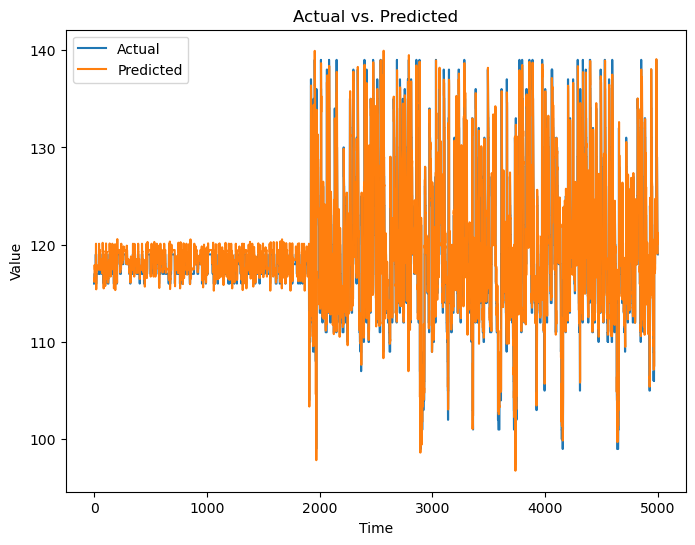

In [28]:
import matplotlib.pyplot as plt

# plot the comparison
plt.figure(figsize=(8, 6))
plt.plot(scaler.inverse_transform(test_labels.cpu().numpy().flatten().reshape(-1, 1))[:5000], label='Actual')
plt.plot(scaler.inverse_transform(np.array(predicted_labels).reshape(-1, 1))[:5000], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Actual vs. Predicted')
plt.show()


In [22]:
df_results.head()

,Epoch,Train Loss,Test Loss,Test MAE,Test MSE,Test RMSE
0,1.0,0.000068,0.000151,0.005934,0.000151,0.012281
1,2.0,0.000427,0.000149,0.005912,0.000149,0.012213
2,3.0,0.000180,0.000144,0.004657,0.000144,0.012008
3,4.0,0.000140,0.000145,0.005511,0.000145,0.012033
4,5.0,0.000064,0.000142,0.004973,0.000142,0.011924


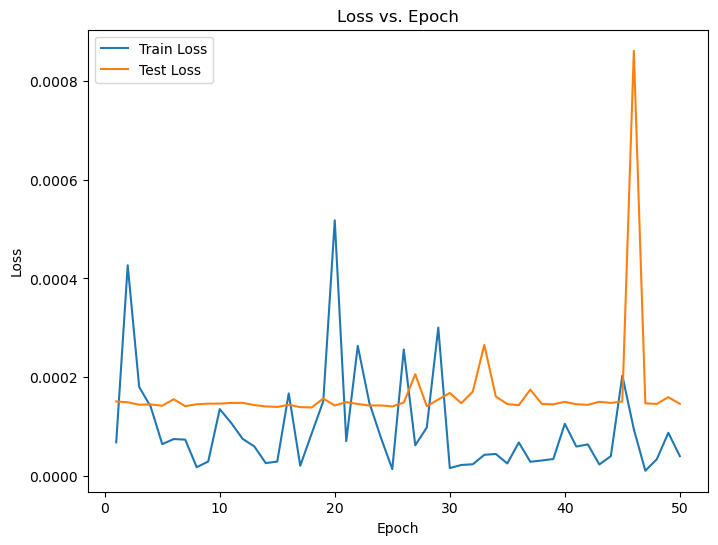

In [26]:
import matplotlib.pyplot as plt

# plot the loss
plt.figure(figsize=(8, 6))
plt.plot(df_results['Epoch'].values, df_results['Train Loss'].values, label='Train Loss')
plt.plot(df_results['Epoch'].values, df_results['Test Loss'].values, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epoch')
plt.show()


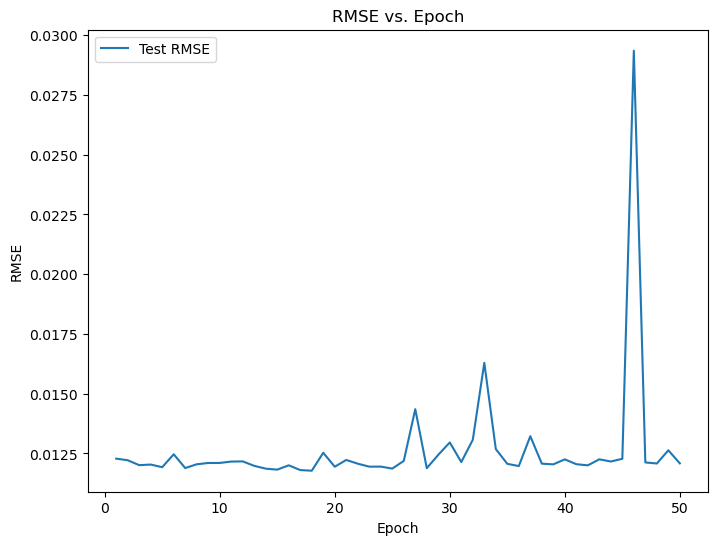

In [27]:
# plot RMSE
plt.figure(figsize=(8, 6))
plt.plot(df_results['Epoch'].values, df_results['Test RMSE'].values, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE vs. Epoch')
plt.show()

In [29]:
df_results

,Epoch,Train Loss,Test Loss,Test MAE,Test MSE,Test RMSE
0,1.0,0.000068,0.000151,0.005934,0.000151,0.012281
1,2.0,0.000427,0.000149,0.005912,0.000149,0.012213
2,3.0,0.000180,0.000144,0.004657,0.000144,0.012008
3,4.0,0.000140,0.000145,0.005511,0.000145,0.012033
4,5.0,0.000064,0.000142,0.004973,0.000142,0.011924
5,6.0,0.000075,0.000155,0.007234,0.000155,0.012462
6,7.0,0.000073,0.000141,0.005090,0.000141,0.011886
7,8.0,0.000018,0.000145,0.005513,0.000145,0.012045
8,9.0,0.000029,0.000146,0.005981,0.000146,0.012098
9,10.0,0.000135,0.000146,0.006289,0.000146,0.012101
